## Model trained on Hazelnut dataset with results. This is version that has binary anomaly map. Not great :)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchmetrics

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode="unmodified"):
        super().__init__()
        assert mode in ["unmodified", "upsample", "downsample"]
        self.mode = mode
        if mode == "unmodified":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU()
            )
        elif mode == "upsample":
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            )
        elif mode == "downsample":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
                nn.ReLU()
            )

        self.id = nn.Identity()

        if in_channels != out_channels or mode == "downsample":
            self.id = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if mode == "downsample" else 1),
            )
        elif mode == "upsample":
            self.id = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        main_path_out = self.block(x)
        shortcut_out = self.id(x)
        if main_path_out.shape != shortcut_out.shape:
            shortcut_out = F.interpolate(shortcut_out, size=main_path_out.shape[2:], mode='nearest')
        return main_path_out + shortcut_out

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.input_net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.body_net = nn.Sequential(
            ResidualBlock(in_channels=32, out_channels=64, mode="downsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),  # Added additional block
            ResidualBlock(in_channels=64, out_channels=128, mode="downsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),  # Added additional block
            ResidualBlock(in_channels=128, out_channels=256, mode="downsample"),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256)  # Added additional block
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        x = self.input_net(x)
        x = self.body_net(x)
        x = self.output_net(x)
        return x

class ResNetDecoder(nn.Module):
    def __init__(self, out_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.out_channels = out_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.inverse_output_net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(256, 4, 4))
        )

        self.inverse_body_net = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=128, mode="upsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),  # Added additional block
            ResidualBlock(in_channels=128, out_channels=64, mode="upsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),  # Added additional block
            ResidualBlock(in_channels=64, out_channels=32, mode="upsample"),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32)  # Added additional block
        )

        self.inverse_input_net = nn.Sequential(
            nn.ConvTranspose2d(32, self.out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inverse_output_net(x)
        x = self.inverse_body_net(x)
        x = self.inverse_input_net(x)
        return x

class Autoencoder(pl.LightningModule):
    def __init__(self, base_channel_size, latent_dim, encoder_class=ResNetEncoder, decoder_class=ResNetDecoder, num_input_channels=3, width=32, height=32):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder_class(num_input_channels, latent_dim)
        self.decoder = decoder_class(num_input_channels, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

# Dataset and DataLoader definition
class HazelnutDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = HazelnutDataset(root_dir='./archive/hazelnut/train/good', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HazelnutDataset(root_dir='./archive/hazelnut/test/good', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = HazelnutDataset(root_dir='./archive/hazelnut/test/crack', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Training the model
# lr_monitor = LearningRateMonitor(logging_interval='epoch')

# model = Autoencoder(base_channel_size=32, latent_dim=256).to('mps')

# Training setup
# checkpoint_callback = ModelCheckpoint(
#     monitor='val_loss',
#     filename='hazelnut_model-{epoch:02d}-{val_loss:.2f}',
#     save_top_k=3,
#     mode='min',
# )
#trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback, lr_monitor], accelerator='mps')

# Train the model
#trainer.fit(model, train_loader, val_loader)

# Manually save the model
#torch.save(model.state_dict(), 'hazelnut_model.pth')

# Loading the model
loaded_model = Autoencoder(base_channel_size=32, latent_dim=256).to('mps')
loaded_model.load_state_dict(torch.load('hazelnut_model.pth'))
loaded_model.eval()


Autoencoder(
  (encoder): ResNetEncoder(
    (input_net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (body_net): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
        )
        (id): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (id): Identity()
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (id): Identity()
      )
      (3): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), pa

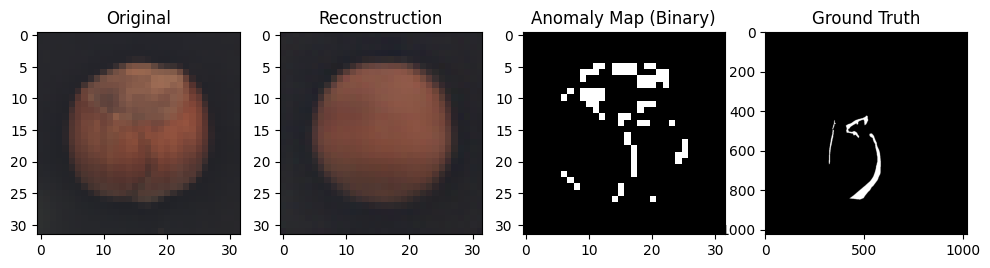

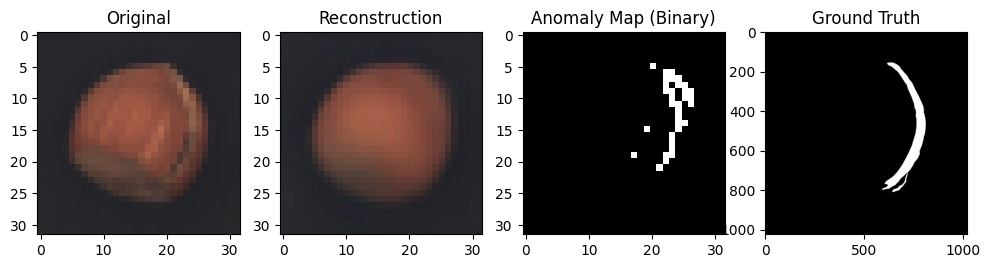

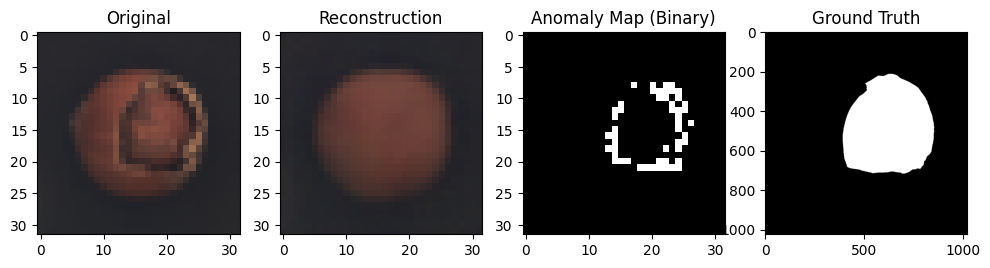

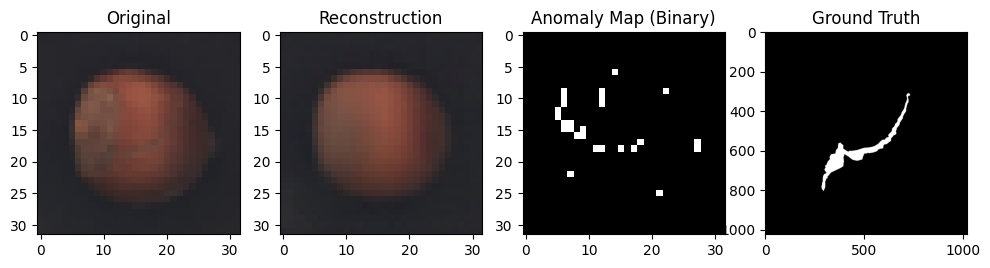

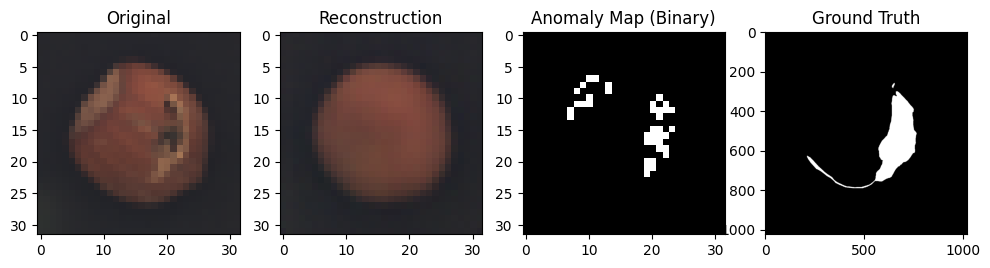

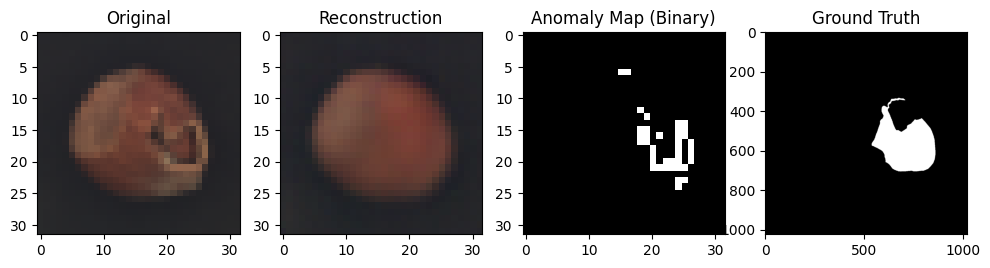

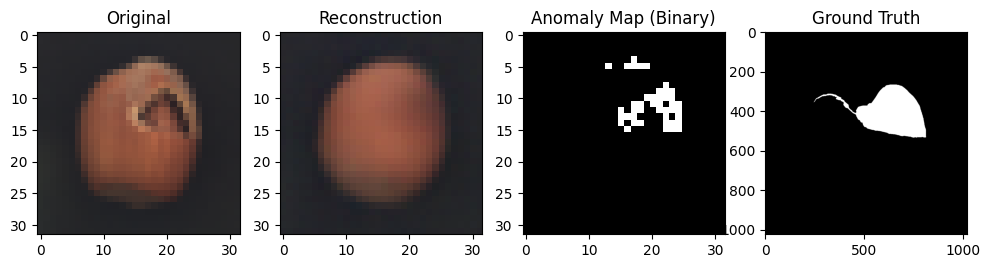

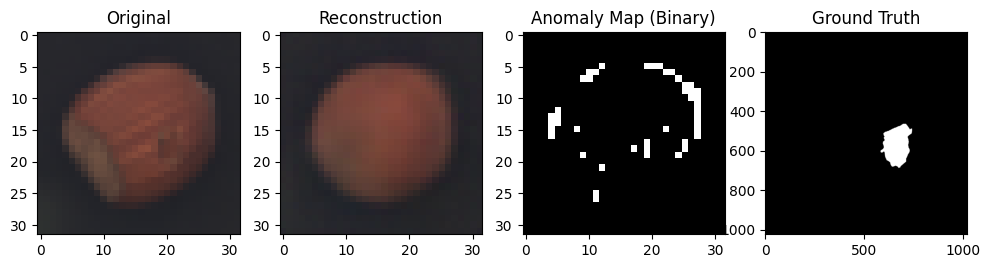

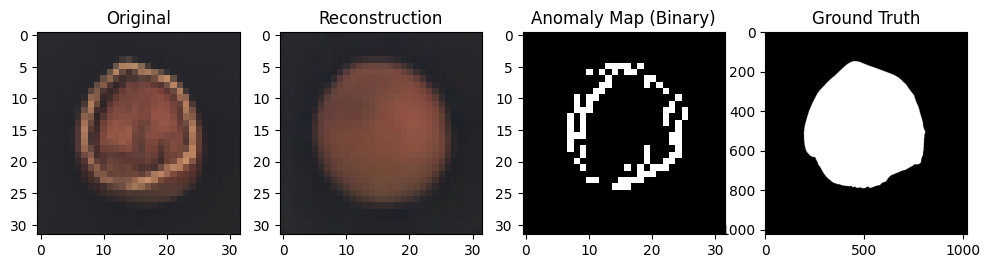

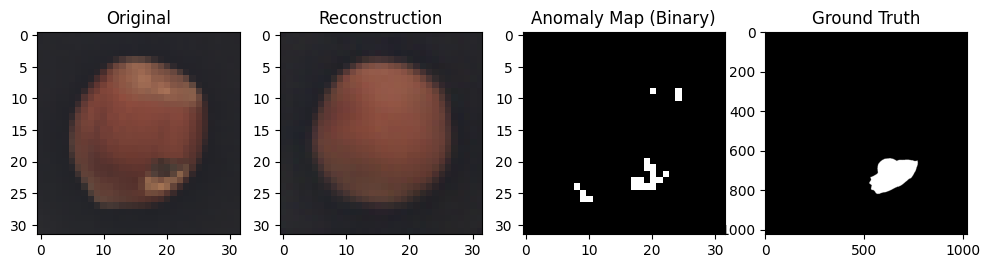

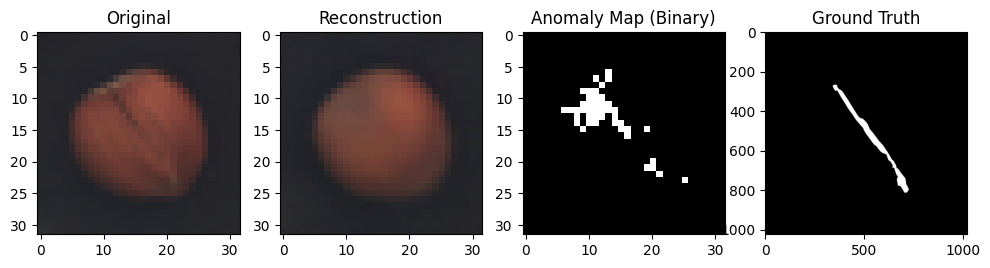

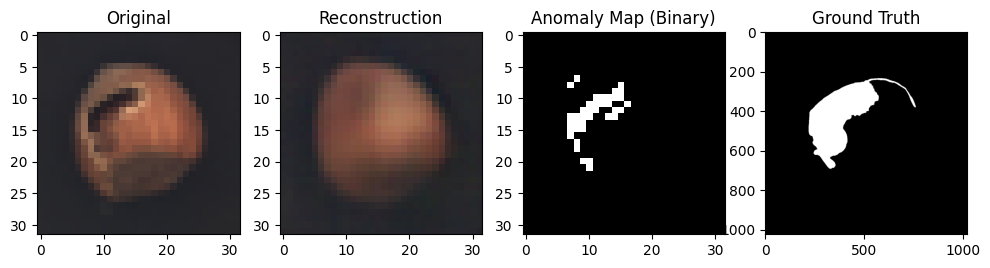

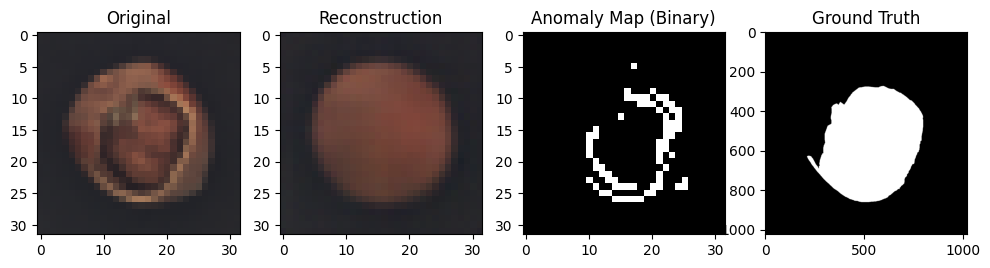

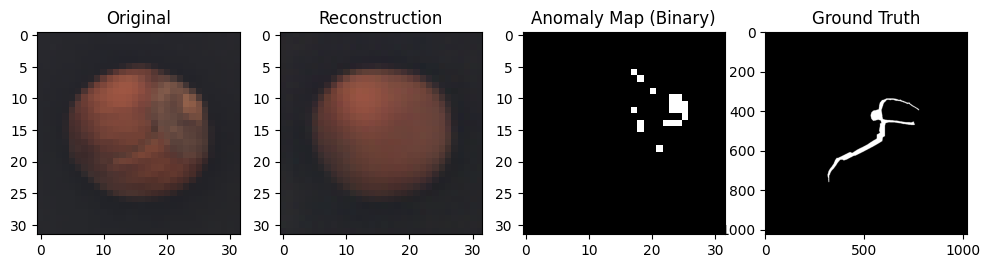

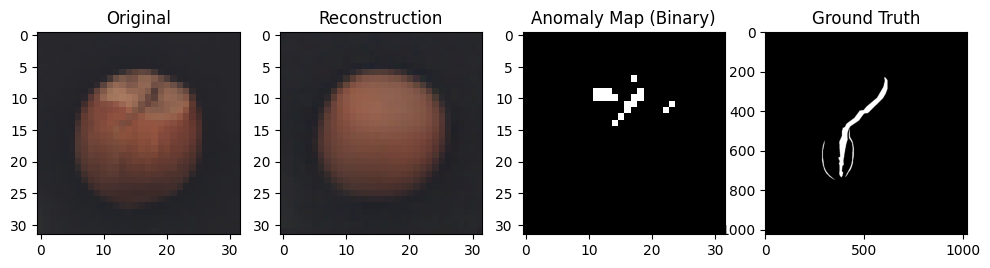

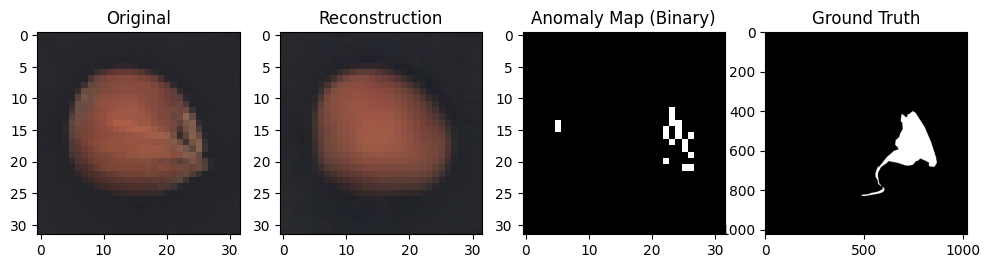

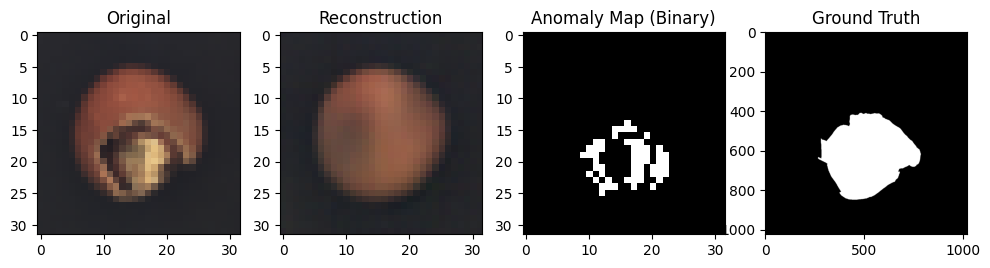

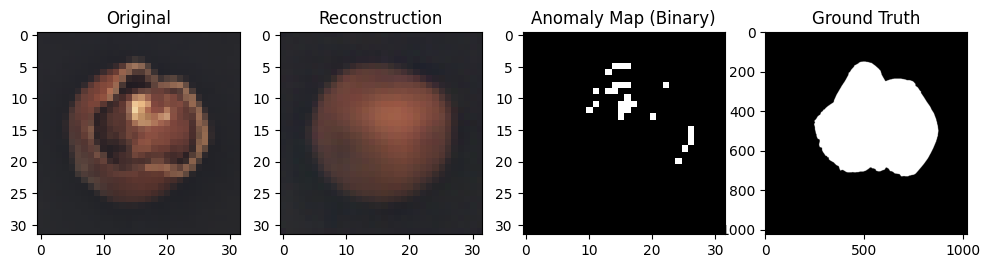

ValueError: Found input variables with inconsistent numbers of samples: [18874368, 18432]

In [20]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage import filters

def detect_anomalies(model, test_loader, ground_truth_dir, threshold=None):
    model.eval()
    anomaly_scores = []
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for batch, img_paths in test_loader:
            batch = batch.to('mps')
            reconstructions = model(batch)
            loss = F.mse_loss(batch, reconstructions, reduction='none')
            loss = loss.sum(dim=[1, 2, 3]).cpu().numpy()
            anomaly_scores.extend(loss)

            for i, img_path in enumerate(img_paths):
                original_img = transforms.ToPILImage()(batch[i].cpu())
                reconstructed_img = transforms.ToPILImage()(reconstructions[i].cpu())

                img_name = os.path.basename(img_path)
                name, ext = os.path.splitext(img_name)
                img_name = f"{name}_mask{ext}"

                ground_truth_path = os.path.join(ground_truth_dir, img_name)
                if os.path.exists(ground_truth_path):
                    ground_truth_img = Image.open(ground_truth_path).convert("L")
                    ground_truth = np.array(ground_truth_img).astype(bool)
                else:
                    ground_truth = np.zeros_like(original_img.convert("L"))  # Assume normal if no ground truth mask is available

                ground_truths.append(ground_truth)

                anomaly_map = torch.mean((batch[i] - reconstructions[i]) ** 2, dim=0).cpu().numpy()
                
                # Normalize the anomaly map
                anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

                # Convert anomaly map to binary
                if threshold is None:
                    threshold = filters.threshold_otsu(anomaly_map)
                binary_anomaly_map = anomaly_map > threshold
                binary_anomaly_map = binary_anomaly_map.astype(np.uint8) * 255

                predictions.append(binary_anomaly_map)

                fig, axs = plt.subplots(1, 4, figsize=(12, 3))
                axs[0].imshow(original_img)
                axs[0].set_title("Original")
                axs[1].imshow(reconstructed_img)
                axs[1].set_title("Reconstruction")
                axs[2].imshow(binary_anomaly_map, cmap='gray')
                axs[2].set_title("Anomaly Map (Binary)")
                if ground_truth_img:
                    axs[3].imshow(ground_truth_img, cmap='gray')
                    axs[3].set_title("Ground Truth")
                else:
                    axs[3].axis('off')
                plt.show()

    # Flatten the lists to calculate metrics
    ground_truths_flat = np.concatenate([gt.flatten() for gt in ground_truths])
    predictions_flat = np.concatenate([pred.flatten() for pred in predictions])

    # Calculate accuracy
    accuracy = accuracy_score(ground_truths_flat, predictions_flat)
    print(f"Accuracy: {accuracy:.4f}")

    # Check distribution of ground truth labels
    unique_labels = np.unique(ground_truths_flat)
    if len(unique_labels) == 1:
        print(f"Only one class present in ground truth: {unique_labels[0]}. AUC-ROC score is not defined in this case.")
        auc_roc = None
    else:
        auc_roc = roc_auc_score(ground_truths_flat, predictions_flat)
        print(f"AUC-ROC: {auc_roc:.4f}")

    return anomaly_scores, auc_roc, accuracy

ground_truth_dir = './archive/hazelnut/ground_truth/crack'
anomaly_scores, auc_roc, accuracy = detect_anomalies(loaded_model, test_loader, ground_truth_dir)


Sa 128 x 128 na 25 epoha

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode="unmodified"):
        super().__init__()
        assert mode in ["unmodified", "upsample", "downsample"]
        self.mode = mode
        if mode == "unmodified":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU()
            )
        elif mode == "upsample":
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            )
        elif mode == "downsample":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
                nn.ReLU()
            )

        self.id = nn.Identity()

        if in_channels != out_channels or mode == "downsample":
            self.id = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if mode == "downsample" else 1),
            )
        elif mode == "upsample":
            self.id = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        main_path_out = self.block(x)
        shortcut_out = self.id(x)
        if main_path_out.shape != shortcut_out.shape:
            shortcut_out = F.interpolate(shortcut_out, size=main_path_out.shape[2:], mode='nearest')
        return main_path_out + shortcut_out


class ResNetEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.input_net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.body_net = nn.Sequential(
            ResidualBlock(in_channels=32, out_channels=64, mode="downsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=128, mode="downsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=256, mode="downsample"),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256)
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Adjusted to pool to 1x1 instead of 4x4
            nn.Flatten(),
            nn.Linear(256*1*1, latent_dim)  # Adjusted to match the pooled size
        )

    def forward(self, x):
        x = self.input_net(x)
        x = self.body_net(x)
        x = self.output_net(x)
        return x



class ResNetDecoder(nn.Module):
    def __init__(self, out_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.out_channels = out_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.inverse_output_net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 1 * 1),  # Adjusted to match the encoder output
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(256, 1, 1))
        )

        self.inverse_body_net = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=128, mode="upsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=64, mode="upsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=32, mode="upsample"),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32)
        )

        self.inverse_input_net = nn.Sequential(
            nn.ConvTranspose2d(32, self.out_channels, kernel_size=4, stride=2, padding=1),  # Adjusted kernel size and padding
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inverse_output_net(x)
        x = self.inverse_body_net(x)
        x = self.inverse_input_net(x)
        return x




class Autoencoder(pl.LightningModule):
    def __init__(self, latent_dim, encoder_class=ResNetEncoder, decoder_class=ResNetDecoder, num_input_channels=3, width=128, height=128):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder_class(num_input_channels, latent_dim)
        self.decoder = decoder_class(num_input_channels, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)


# Dataset and DataLoader definition
class HazelnutDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = HazelnutDataset(root_dir='./archive/hazelnut/train/good', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HazelnutDataset(root_dir='./archive/hazelnut/test/good', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = HazelnutDataset(root_dir='./archive/hazelnut/test/crack', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Training the model
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = Autoencoder(latent_dim=256).to('mps')

# Training setup
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='hazelnut_model2-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)
trainer = pl.Trainer(max_epochs=25, callbacks=[checkpoint_callback, lr_monitor], accelerator='mps')

# Train the model
trainer.fit(model, train_loader, val_loader)

# Manually save the model
torch.save(model.state_dict(), 'hazelnut_model2.pth')

# Loading the model
loaded_model = Autoencoder(base_channel_size=32, latent_dim=256).to('mps')
loaded_model.load_state_dict(torch.load('hazelnut_model2.pth'))
loaded_model.eval()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | encoder | ResNetEncoder | 2.0 M  | train
1 | decoder | ResNetDecoder | 1.2 M  | train
--------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.933    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/nr/yzg_nf3s5zld2lpjkmg7svv80000gn/T/ipykernel_5082/2099085352.py:146: UserWarning: Using a target size (torch.Size([32, 3, 16, 16])) that is different to the input size (torch.Size([32, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, x_hat, reduction="none")


RuntimeError: The size of tensor a (128) must match the size of tensor b (16) at non-singleton dimension 3